In [79]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(1, '/Users/samuele/University/2.DM2/DataMining-2/utility_functions.py')

from utility_functions import report, summarize

# sklearn modules
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, recall_score, precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from IPython.display import display
import plotly.graph_objects as go

import plotly.express as px
import matplotlib.pyplot as plt
import utils

import warnings
warnings.filterwarnings('ignore')

# Dataset reading

In [2]:
features = utils.load('/Users/samuele/University/2.DM2/fma_metadata/features.csv')
results = list()

In [3]:
gen_labels = pd.read_csv('/Users/samuele/University/2.DM2/fma_metadata/labels_genre_top.csv')
gen_labels.head()
#gen_labels.set_index('track_id', inplace=True)
#gen_labels.head()

,track_id,genre_top
0,2,Hip-Hop
1,3,Hip-Hop
2,5,Hip-Hop
3,10,Pop
4,134,Hip-Hop


 _______________________________________________
# Binary Classification - Rock & Jazz
## Librosa features (All features)
## 1. Preprocessing
 _______________________________________________

In [4]:
all_features = features.merge(gen_labels, on = 'track_id')
all_features.head()

,track_id,"(chroma_cens, kurtosis, 01)","(chroma_cens, kurtosis, 02)","(chroma_cens, kurtosis, 03)","(chroma_cens, kurtosis, 04)","(chroma_cens, kurtosis, 05)","(chroma_cens, kurtosis, 06)","(chroma_cens, kurtosis, 07)","(chroma_cens, kurtosis, 08)","(chroma_cens, kurtosis, 09)",...,"(tonnetz, std, 05)","(tonnetz, std, 06)","(zcr, kurtosis, 01)","(zcr, max, 01)","(zcr, mean, 01)","(zcr, median, 01)","(zcr, min, 01)","(zcr, skew, 01)","(zcr, std, 01)",genre_top
0,2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,...,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.0,2.089872,0.061448,Hip-Hop
1,3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,...,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.0,1.716724,0.069330,Hip-Hop
2,5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,...,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.0,2.193303,0.044861,Hip-Hop
3,10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,...,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.0,3.542325,0.040800,Pop
4,134,0.918445,0.674147,0.577818,1.281117,0.933746,0.078177,1.199204,-0.175223,0.925482,...,0.016322,0.015819,4.731087,0.419434,0.064370,0.050781,0.0,1.806106,0.054623,Hip-Hop


In [5]:
#delete null values
all_features.dropna(axis=0, inplace=True)
all_features.isnull().sum()

track_id                       0
(chroma_cens, kurtosis, 01)    0
(chroma_cens, kurtosis, 02)    0
(chroma_cens, kurtosis, 03)    0
(chroma_cens, kurtosis, 04)    0
                              ..
(zcr, median, 01)              0
(zcr, min, 01)                 0
(zcr, skew, 01)                0
(zcr, std, 01)                 0
genre_top                      0
Length: 520, dtype: int64

In [6]:
#keep only rock and jazz tracks
genres = ['Rock', 'Jazz']
all_features = all_features[all_features['genre_top'].isin(genres)]
display(all_features.genre_top.value_counts())
display(all_features.head())

Rock    14182
Jazz      571
Name: genre_top, dtype: int64

,track_id,"(chroma_cens, kurtosis, 01)","(chroma_cens, kurtosis, 02)","(chroma_cens, kurtosis, 03)","(chroma_cens, kurtosis, 04)","(chroma_cens, kurtosis, 05)","(chroma_cens, kurtosis, 06)","(chroma_cens, kurtosis, 07)","(chroma_cens, kurtosis, 08)","(chroma_cens, kurtosis, 09)",...,"(tonnetz, std, 05)","(tonnetz, std, 06)","(zcr, kurtosis, 01)","(zcr, max, 01)","(zcr, mean, 01)","(zcr, median, 01)","(zcr, min, 01)","(zcr, skew, 01)","(zcr, std, 01)",genre_top
5,135,0.978402,0.623572,1.129261,-1.043970,-1.127288,-0.032642,-0.878434,-0.916234,-0.743257,...,0.016731,0.020464,-0.038451,0.234863,0.050837,0.050781,0.003418,0.297873,0.024899,Rock
6,136,0.915001,-0.643476,-0.460507,-0.530701,-0.364460,-0.226860,-0.060377,-0.267673,-0.063476,...,0.017915,0.016706,0.558770,0.147461,0.036686,0.034180,0.003418,0.805020,0.016905,Rock
13,144,0.121207,-0.025308,0.541327,0.967687,1.082456,1.675841,1.741263,0.470098,4.051888,...,0.019886,0.018568,0.627553,0.239258,0.079759,0.078613,0.000000,0.226211,0.034378,Jazz
14,145,0.954054,0.315324,0.015383,-0.023933,0.086671,1.279086,1.966359,0.517441,0.372864,...,0.020350,0.016222,3.367346,0.288574,0.070751,0.067871,0.000000,1.064697,0.029904,Jazz
15,146,-0.763713,-0.342105,-0.273965,0.729047,-0.649717,0.109572,-0.588591,-0.141158,-0.314764,...,0.020644,0.026361,12.003415,0.472168,0.085446,0.089355,0.002441,1.567211,0.039701,Jazz


#### Selecting genres for classification

In [7]:
# encoding labels for classificaiton
le = preprocessing.LabelEncoder()
all_features['genre_top'] = le.fit_transform(all_features['genre_top'])
print(f'Legend:\n1: Rock\n0: {genres[1]}')
all_features.genre_top.value_counts()

Legend:
1: Rock
0: Jazz


1    14182
0      571
Name: genre_top, dtype: int64

In [8]:
# Define the labels
labels = all_features[['genre_top']]
# labels has as index the id_track, this creates problems when plotting data after the features have been normalized.
# we reset the index from 0 to n
labels.reset_index(drop=True, inplace=True)
labels = labels['genre_top']

In [9]:
# detach labels from mfcc dataset
all_features.drop('genre_top', axis=1, inplace=True)
display(all_features.head()) 
display(labels)

,track_id,"(chroma_cens, kurtosis, 01)","(chroma_cens, kurtosis, 02)","(chroma_cens, kurtosis, 03)","(chroma_cens, kurtosis, 04)","(chroma_cens, kurtosis, 05)","(chroma_cens, kurtosis, 06)","(chroma_cens, kurtosis, 07)","(chroma_cens, kurtosis, 08)","(chroma_cens, kurtosis, 09)",...,"(tonnetz, std, 04)","(tonnetz, std, 05)","(tonnetz, std, 06)","(zcr, kurtosis, 01)","(zcr, max, 01)","(zcr, mean, 01)","(zcr, median, 01)","(zcr, min, 01)","(zcr, skew, 01)","(zcr, std, 01)"
5,135,0.978402,0.623572,1.129261,-1.043970,-1.127288,-0.032642,-0.878434,-0.916234,-0.743257,...,0.104279,0.016731,0.020464,-0.038451,0.234863,0.050837,0.050781,0.003418,0.297873,0.024899
6,136,0.915001,-0.643476,-0.460507,-0.530701,-0.364460,-0.226860,-0.060377,-0.267673,-0.063476,...,0.076808,0.017915,0.016706,0.558770,0.147461,0.036686,0.034180,0.003418,0.805020,0.016905
13,144,0.121207,-0.025308,0.541327,0.967687,1.082456,1.675841,1.741263,0.470098,4.051888,...,0.082813,0.019886,0.018568,0.627553,0.239258,0.079759,0.078613,0.000000,0.226211,0.034378
14,145,0.954054,0.315324,0.015383,-0.023933,0.086671,1.279086,1.966359,0.517441,0.372864,...,0.086215,0.020350,0.016222,3.367346,0.288574,0.070751,0.067871,0.000000,1.064697,0.029904
15,146,-0.763713,-0.342105,-0.273965,0.729047,-0.649717,0.109572,-0.588591,-0.141158,-0.314764,...,0.131701,0.020644,0.026361,12.003415,0.472168,0.085446,0.089355,0.002441,1.567211,0.039701


0        1
1        1
2        0
3        0
4        0
        ..
14748    1
14749    1
14750    1
14751    1
14752    1
Name: genre_top, Length: 14753, dtype: int64

In [10]:
# normalize the dataset
scaler = StandardScaler()
all_scaled_features = scaler.fit_transform(all_features)
all_features.head()

,track_id,"(chroma_cens, kurtosis, 01)","(chroma_cens, kurtosis, 02)","(chroma_cens, kurtosis, 03)","(chroma_cens, kurtosis, 04)","(chroma_cens, kurtosis, 05)","(chroma_cens, kurtosis, 06)","(chroma_cens, kurtosis, 07)","(chroma_cens, kurtosis, 08)","(chroma_cens, kurtosis, 09)",...,"(tonnetz, std, 04)","(tonnetz, std, 05)","(tonnetz, std, 06)","(zcr, kurtosis, 01)","(zcr, max, 01)","(zcr, mean, 01)","(zcr, median, 01)","(zcr, min, 01)","(zcr, skew, 01)","(zcr, std, 01)"
5,135,0.978402,0.623572,1.129261,-1.043970,-1.127288,-0.032642,-0.878434,-0.916234,-0.743257,...,0.104279,0.016731,0.020464,-0.038451,0.234863,0.050837,0.050781,0.003418,0.297873,0.024899
6,136,0.915001,-0.643476,-0.460507,-0.530701,-0.364460,-0.226860,-0.060377,-0.267673,-0.063476,...,0.076808,0.017915,0.016706,0.558770,0.147461,0.036686,0.034180,0.003418,0.805020,0.016905
13,144,0.121207,-0.025308,0.541327,0.967687,1.082456,1.675841,1.741263,0.470098,4.051888,...,0.082813,0.019886,0.018568,0.627553,0.239258,0.079759,0.078613,0.000000,0.226211,0.034378
14,145,0.954054,0.315324,0.015383,-0.023933,0.086671,1.279086,1.966359,0.517441,0.372864,...,0.086215,0.020350,0.016222,3.367346,0.288574,0.070751,0.067871,0.000000,1.064697,0.029904
15,146,-0.763713,-0.342105,-0.273965,0.729047,-0.649717,0.109572,-0.588591,-0.141158,-0.314764,...,0.131701,0.020644,0.026361,12.003415,0.472168,0.085446,0.089355,0.002441,1.567211,0.039701


# 2. PCA on normalized data 

Text(0.5, 0, 'Principal Component #')

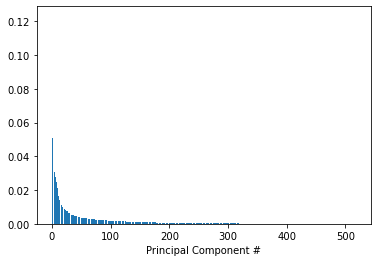

In [11]:
pca = PCA()
pca.fit(all_scaled_features)
# get explained variance ratios from PCA using all features
exp_variance = pca.explained_variance_ratio_
# plot explained variance
fig, ax= plt.subplots()
ax.bar(range(pca.n_components_),exp_variance)
ax.set_xlabel('Principal Component #')

Optimal number of components: 141


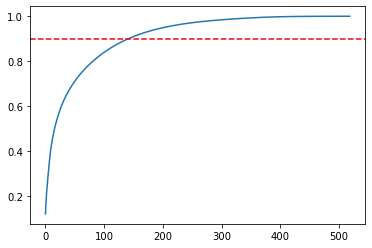

In [12]:
# calculate the cumulative explained variance
cum_exp_var = np.cumsum(exp_variance)

# plot the cumulative explained variance and draw a dashed line at 0.9\
# This line indicates how much variance (information) we want to retain
fig, ax= plt.subplots()
ax.plot(cum_exp_var)
ax.axhline(y=0.9, linestyle='--',color='red')

# find index where cum_exp_var exceeds 0.9 and adding 1 to that index to get the num of components
n_components = ((np.where(cum_exp_var > 0.9))[0][0])
print(f"Optimal number of components: {n_components}")
# perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components=n_components,random_state=10)
pca.fit(all_scaled_features)
pca_proj = pca.transform(all_scaled_features)

In [13]:
# check number of tracks and principal components chosen
pca_proj.shape

(14753, 141)

### Plot PCA 

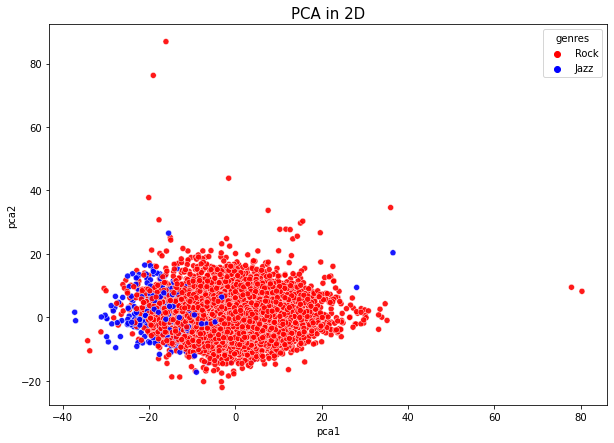

In [14]:
# generating df for plotting PCA
df = pd.DataFrame()
df['pca1'] = pca_proj[:,0]
df['pca2'] = pca_proj[:,1]
df['pca3'] = pca_proj[:,2] # for plotting in 3D
df['genres'] = labels.apply(lambda x: "Rock" if x==1 else str(genres[1]))

# plot scatter of PCA
plt.figure(figsize=(10,7))
sns.scatterplot(
    x="pca1", y="pca2",
    hue='genres',
    palette={str(genres[1]):'blue','Rock':'red'},
    data=df,
    legend="full",
    alpha=0.9
)
plt.title("PCA in 2D", fontsize= 15)
plt.show()

# 3. Split data for classification

In [15]:
# shuffle and split into development set and internal test set:
# (PCA)
Xpca_develop, Xpca_test, y_develop_pca, y_test_pca = train_test_split(
pca_proj, labels, test_size=0.30, random_state=42, stratify=labels)

# (split without PCA)
X_develop, X_test, y_develop, y_test = train_test_split(
all_scaled_features, labels, test_size=0.30, random_state=42, stratify= labels)

In [16]:
# check partition
print(f"____Legend____\n1: Rock\n0: Jazz\n\n***PCA***\nDevelopment set:\
\n{y_develop_pca.value_counts()}\n\nInternal Test:\n{y_test_pca.value_counts()}\n\n\
-----------------\n\
***No-PCA***\nDevelopment set:\n{y_develop.value_counts()}\n\nInternal Test:\n{y_test.value_counts()}")

____Legend____
1: Rock
0: Jazz

***PCA***
Development set:
1    9927
0     400
Name: genre_top, dtype: int64

Internal Test:
1    4255
0     171
Name: genre_top, dtype: int64

-----------------
***No-PCA***
Development set:
1    9927
0     400
Name: genre_top, dtype: int64

Internal Test:
1    4255
0     171
Name: genre_top, dtype: int64


# 4. Decision Tree
## a) without PCA 

In [19]:
# search parameters
param_grid = {
               "max_depth": [3,4,5,6,7,8,9,10],
               "min_samples_leaf": [10,15,20,25,20,35,40,45,50,55,75],
               "criterion": ["gini", "entropy"]
             }

# instantiate a model
dtc = DecisionTreeClassifier()
rep_kfold = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2652124)
clf = GridSearchCV(dtc, cv =rep_kfold , param_grid=param_grid, n_jobs=2, verbose=True)
clf.fit(X_develop, y_develop)
# display top 3 models
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")
report(clf.cv_results_)

Fitting 50 folds for each of 176 candidates, totalling 8800 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  4.7min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  9.1min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed: 23.2min
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed: 32.9min
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed: 46.5min
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed: 64.4min
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed: 88.2min
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed: 107.2min
[Parallel(n_jobs=2)]: Done 6046 tasks      | elapsed: 128.2min
[Parallel(n_jobs=2)]: Done 7196 tasks      | elapsed: 154.7min
[Parallel(n_jobs=2)]: Done 8446 tasks      | elapsed: 185.6min
[Parallel(n_jobs=2)]: Done 8800 out of 8800 | elapsed: 193.8min finished


best parameters:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 75}
accuracy: 0.9639203756650683


NameError: name 'report' is not defined

In [17]:
# train and fit
dtc = DecisionTreeClassifier(criterion= 'entropy',max_depth=5, min_samples_leaf=75)
dtc.fit(X_develop,y_develop)
# predict on internal test set
y_pred_dtc = dtc.predict(X_test)

# display metrics
print('Accuracy %s' % accuracy_score(y_test, y_pred_dtc))
print('F1-score %s' % f1_score(y_test, y_pred_dtc, average=None))
print(classification_report(y_test, y_pred_dtc))

Accuracy 0.9627202892001807
F1-score [0.28571429 0.98086069]
              precision    recall  f1-score   support

           0       0.55      0.19      0.29       171
           1       0.97      0.99      0.98      4255

    accuracy                           0.96      4426
   macro avg       0.76      0.59      0.63      4426
weighted avg       0.95      0.96      0.95      4426



In [18]:
dt = {
    'name': 'Decision Tree', 
    'accuracy': accuracy_score(y_test, y_pred_dtc), 
    'f1_score': f1_score(y_test, y_pred_dtc, average=None)[0], 
    'precision': precision_score(y_test, y_pred_dtc, average=None)[0], 
    'recall': recall_score(y_test, y_pred_dtc, average=None)[0]
}
results.append(dt)
dt

{'name': 'Decision Tree',
 'accuracy': 0.9627202892001807,
 'f1_score': 0.2857142857142857,
 'precision': 0.55,
 'recall': 0.19298245614035087}

### ROC Curve

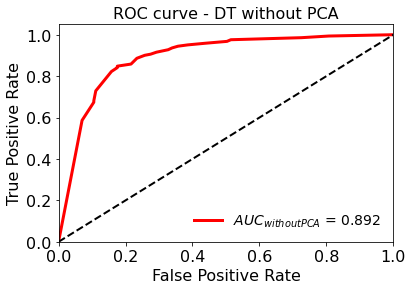

In [26]:
# y_score0 --> scores of decision tree without PCA
# fpr0, tpr0 ---> false positive and true positive of decision tree without PCA
y_score0 = dtc.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score0[:, 1])

# roc_auc0 --> ROC/AUC of decision tree without PCA
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='red', lw=3, label='$AUC_{without PCA}$ = %.3f' % roc_auc_dt)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve - DT without PCA', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### Confusion matrix

Legend:
0: Jazz
1: Rock
[[  33  138]
 [  27 4228]]


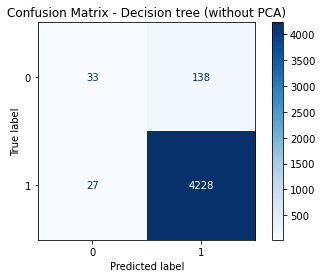

In [20]:
# confusion matrix - Internal Test
print("Legend:\n0: Jazz"
      "\n1: Rock")
cm = plot_confusion_matrix(dtc,X_test,y_test,
                            cmap = plt.cm.Blues)
cm.ax_.set_title('Confusion Matrix - Decision tree (without PCA)')
print(cm.confusion_matrix)
plt.show()

### b) with PCA 

In [24]:
# search parameters
param_grid = {
               "max_depth": [3,4,5,6,7,8,9,10],
               "min_samples_leaf": [10,15,20,25,20,35,40,45,50,55,75],
               "criterion": ["gini", "entropy"]
             }

# model
dtc_pca = DecisionTreeClassifier()
rep_kfold = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2652124)
clf = GridSearchCV(dtc_pca, cv =rep_kfold , param_grid=param_grid, n_jobs=2, verbose=True)

clf.fit(Xpca_develop, y_develop_pca)
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")

report(clf.cv_results_)

Fitting 50 folds for each of 176 candidates, totalling 8800 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.7s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   36.8s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  4.6min
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  7.3min
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed: 11.2min
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed: 16.4min
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed: 23.1min
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed: 28.3min
[Parallel(n_jobs=2)]: Done 6046 tasks      | elapsed: 34.2min
[Parallel(n_jobs=2)]: Done 7196 tasks      | elapsed: 42.2min
[Parallel(n_jobs=2)]: Done 8446 tasks      | elapsed: 51.4min
[Parallel(n_jobs=2)]: Done 8800 out of 8800 | elapsed: 54.0min finished


best parameters:
{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 75}
accuracy: 0.9616928941819194


NameError: name 'report' is not defined

In [21]:
dtc_pca = DecisionTreeClassifier(criterion= 'entropy',max_depth=4, min_samples_leaf= 75)
dtc_pca.fit(Xpca_develop,y_develop_pca)

y_pred_dtc_pca = dtc_pca.predict(Xpca_test)

print('Accuracy %s' % accuracy_score(y_test_pca, y_pred_dtc_pca))
print('F1-score %s' % f1_score(y_test_pca, y_pred_dtc_pca, average=None))
print(classification_report(y_test_pca, y_pred_dtc_pca))

Accuracy 0.9627202892001807
F1-score [0.29184549 0.98085625]
              precision    recall  f1-score   support

           0       0.55      0.20      0.29       171
           1       0.97      0.99      0.98      4255

    accuracy                           0.96      4426
   macro avg       0.76      0.60      0.64      4426
weighted avg       0.95      0.96      0.95      4426



In [22]:
dt = {
    'name': 'PCA Decision Tree', 
    'accuracy': accuracy_score(y_test_pca, y_pred_dtc_pca), 
    'f1_score': f1_score(y_test_pca, y_pred_dtc_pca, average=None)[0], 
    'precision': precision_score(y_test_pca, y_pred_dtc_pca, average=None)[0], 
    'recall': recall_score(y_test_pca, y_pred_dtc_pca, average=None)[0]
}
results.append(dt)
dt

{'name': 'PCA Decision Tree',
 'accuracy': 0.9627202892001807,
 'f1_score': 0.2918454935622318,
 'precision': 0.5483870967741935,
 'recall': 0.19883040935672514}

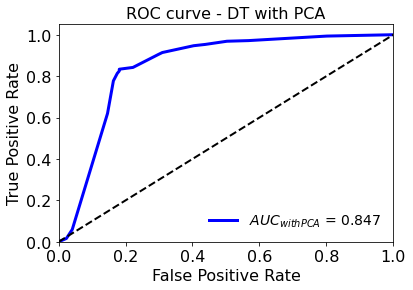

In [23]:
# y_score1 --> scores of decision tree with PCA
# fpr1, tpr1 ---> false positive and true positive of decision tree with PCA
y_score1 = dtc_pca.predict_proba(Xpca_test)
fpr1, tpr1, _ = roc_curve(y_test_pca, y_score1[:, 1])

# roc_auc1 --> ROC/AUC of decision tree with PCA
roc_auc1 = auc(fpr1, tpr1)

plt.plot(fpr1, tpr1, color='blue', lw=3, label='$AUC_{with PCA}$ = %.3f' % roc_auc1)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve - DT with PCA', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Legend:
0: Jazz
1: Rock
[[  34  137]
 [  28 4227]]


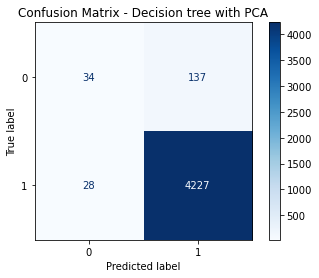

In [24]:
# confusion matrix Decision tree with PCA
print("Legend:\n0: Jazz\n1: Rock")
cm_pca = plot_confusion_matrix(dtc_pca,Xpca_test,y_test_pca,
                            cmap = plt.cm.Blues)
cm_pca.ax_.set_title('Confusion Matrix - Decision tree with PCA')
print(cm_pca.confusion_matrix)
plt.show()

#### Comparing Decision Tree with and without PCA

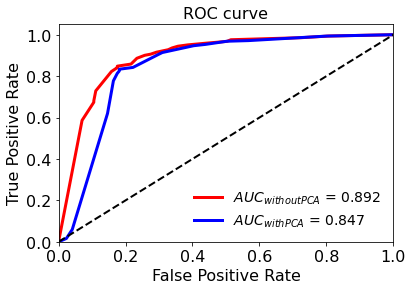

In [27]:
# ROC of decision tree without PCA
plt.plot(fpr0, tpr0, color='red', lw=3, label='$AUC_{without PCA}$ = %.3f' % roc_auc0)
# ROC of decision tree with PCA
plt.plot(fpr1, tpr1, color='blue', lw=3, label='$AUC_{with PCA}$ = %.3f' % roc_auc1)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# 5. KNN
### a. without PCA

In [25]:
# range of k to try - find a good range of k
k_range = {"n_neighbors":[x for x in range(2, 50)]}

knn = KNeighborsClassifier()
rep_kfold = RepeatedKFold(n_splits=10, n_repeats=2, random_state=2652124)
clf = GridSearchCV(knn, param_grid= k_range, cv=rep_kfold )
clf.fit(X_develop, y_develop)
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")

KeyboardInterrupt: 

In [28]:
knn =  KNeighborsClassifier(n_neighbors = 5, weights='distance')
# retrain knn on the whole development set
knn.fit(X_develop, y_develop)
# predict target variable
y_pred_knn0 = knn.predict(X_test)

# display classification report
print(classification_report(y_test, y_pred_knn0))
print('legend:\n0: Jazz\n1: Rock')

              precision    recall  f1-score   support

           0       0.74      0.55      0.63       171
           1       0.98      0.99      0.99      4255

    accuracy                           0.98      4426
   macro avg       0.86      0.77      0.81      4426
weighted avg       0.97      0.98      0.97      4426

legend:
0: Jazz
1: Rock


In [29]:
dt = {
    'name': 'KNN', 
    'accuracy': accuracy_score(y_test, y_pred_knn0), 
    'f1_score': f1_score(y_test, y_pred_knn0, average=None)[0], 
    'precision': precision_score(y_test, y_pred_knn0, average=None)[0], 
    'recall': recall_score(y_test, y_pred_knn0, average=None)[0]
}
results.append(dt)
dt

{'name': 'KNN',
 'accuracy': 0.9751468594667871,
 'f1_score': 0.6308724832214764,
 'precision': 0.7401574803149606,
 'recall': 0.5497076023391813}

#### ROC curve

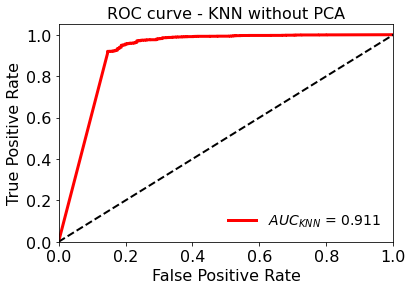

In [30]:
y_score_knn0 = knn.predict_proba(X_test)
fpr_knn0, tpr_knn0, _ = roc_curve(y_test, y_score_knn0[:, 1])
roc_auc_knn0 = auc(fpr_knn0, tpr_knn0)

plt.plot(fpr_knn0, tpr_knn0, color='red', lw=3, label='$AUC_{KNN}$ = %.3f' % roc_auc_knn0)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve - KNN without PCA', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

#### Confusion matrix

Legend:
0: Jazz
1: Rock
[[  94   77]
 [  33 4222]]


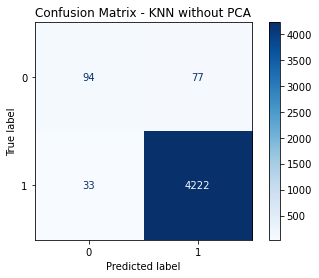

In [32]:
# confusion matrix KNN - Internal test
print("Legend:\n0: Jazz\n1: Rock")
cm_knn = plot_confusion_matrix(knn,X_test,y_test,
                            cmap = plt.cm.Blues)
cm_knn.ax_.set_title('Confusion Matrix - KNN without PCA')
print(cm_knn.confusion_matrix)
plt.show()

## b. with PCA 

In [43]:
# range of k to try - find a good range of k
k_range = {"n_neighbors":[x for x in range(2, 50)]}

knn = KNeighborsClassifier()
rep_kfold = RepeatedKFold(n_splits=10, n_repeats=2, random_state=2652124)
clf = GridSearchCV(knn, param_grid= k_range, cv=rep_kfold )
clf.fit(Xpca_develop, y_develop_pca)
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")

#report(clf.cv_results_)

best parameters:
{'n_neighbors': 5}
accuracy: 0.9737105274019375


### Train and predict 

In [33]:
knn_pca =  KNeighborsClassifier(n_neighbors = 5, weights='distance')
# retrain knn on the whole development set
knn_pca.fit(Xpca_develop, y_develop_pca)
# predict target variable
y_pred_knn1 = knn_pca.predict(Xpca_test)
# display classification report
print(classification_report(y_test_pca, y_pred_knn1))
print('legend:\n0: Jazz\n1: Rock')

              precision    recall  f1-score   support

           0       0.71      0.54      0.61       171
           1       0.98      0.99      0.99      4255

    accuracy                           0.97      4426
   macro avg       0.85      0.76      0.80      4426
weighted avg       0.97      0.97      0.97      4426

legend:
0: Jazz
1: Rock


In [34]:
dt = {
    'name': 'PCA KNN', 
    'accuracy': accuracy_score(y_test_pca, y_pred_knn1), 
    'f1_score': f1_score(y_test_pca, y_pred_knn1, average=None)[0], 
    'precision': precision_score(y_test_pca, y_pred_knn1, average=None)[0], 
    'recall': recall_score(y_test_pca, y_pred_knn1, average=None)[0]
}
results.append(dt)
dt

{'name': 'PCA KNN',
 'accuracy': 0.973791233619521,
 'f1_score': 0.6133333333333333,
 'precision': 0.7131782945736435,
 'recall': 0.5380116959064327}

#### ROC curve 

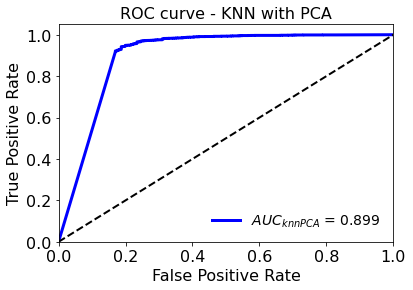

In [36]:
y_score_knn1 = knn_pca.predict_proba(Xpca_test)
fpr_knn1, tpr_knn1, _ = roc_curve(y_test_pca, y_score_knn1[:, 1])
roc_auc_knn1 = auc(fpr_knn1, tpr_knn1)

plt.plot(fpr_knn1, tpr_knn1, color='blue', lw=3, label='$AUC_{knnPCA}$ = %.3f' % roc_auc_knn1)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve - KNN with PCA', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

#### Confusion matrix

Legend:
0: Jazz
1: Rock
[[  92   79]
 [  37 4218]]


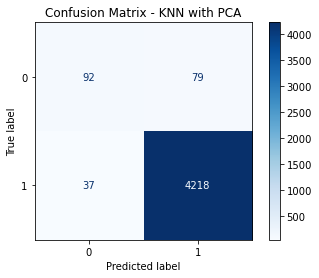

In [37]:
print("Legend:\n0: Jazz\n1: Rock")
cm_knn_pca = plot_confusion_matrix(knn_pca,Xpca_test,y_test_pca,
                            cmap = plt.cm.Blues)
cm_knn_pca.ax_.set_title('Confusion Matrix - KNN with PCA')
print(cm_knn_pca.confusion_matrix)
plt.show()

### c. compating KNN with and without PCA 

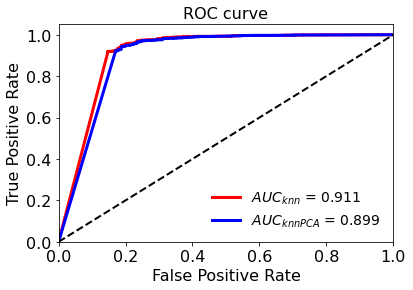

In [38]:
# ROC KNN without PCA
plt.plot(fpr_knn0, tpr_knn0, color='red', lw=3, label='$AUC_{knn}$ = %.3f' % roc_auc_knn0)
# ROC KNN with PCA
plt.plot(fpr_knn1, tpr_knn1, color='blue', lw=3, label='$AUC_{knnPCA}$ = %.3f' % roc_auc_knn1)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

## Compare Decision Tree and KNN best scores 

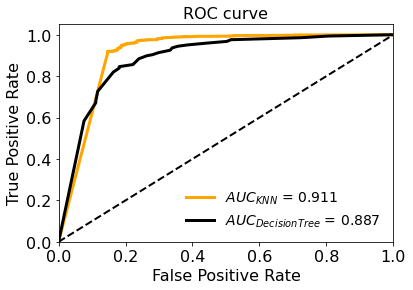

In [56]:
plt.plot(fpr_knn0, tpr_knn0, color='orange', lw=3, label='$AUC_{KNN}$ = %.3f' % roc_auc_knn0)
plt.plot(fpr0, tpr0, color='black', lw=3, label='$AUC_{DecisionTree}$ = %.3f' % roc_auc_dt)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# Librosa Features (SelectFromModel Feature Selection) 
# Decision Tree

In [39]:
sel = SelectFromModel(DecisionTreeClassifier())
X_develop_sel = sel.fit_transform(X_develop, y_develop)
X_develop_sel.shape

(10327, 132)

In [40]:
print(f"Number of features after reduction: {X_develop_sel.shape[1]}\nNumber of Features removed: {len(all_features.columns)-X_develop_sel.shape[1]}")

Number of features after reduction: 132
Number of Features removed: 387


In [41]:
X_test_sel = sel.transform(X_test)

In [70]:
# search parameters
param_grid = {
               "max_depth": [3,4,5,6,7,8,9,10],
               "min_samples_leaf": [10,15,20,25,20,35,40,45,50,55,75],
               "criterion": ["gini", "entropy"]
             }

# instantiate a model
dtc = DecisionTreeClassifier()
rep_kfold = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2652124)
clf = GridSearchCV(dtc, cv =rep_kfold , param_grid=param_grid, n_jobs=2, verbose=True)
clf.fit(X_develop_sel, y_develop)
# display top 3 models
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")
report(clf.cv_results_)

Fitting 50 folds for each of 176 candidates, totalling 8800 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   11.8s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   36.6s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  6.8min
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed: 10.4min
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed: 15.2min
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed: 21.6min
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed: 26.5min
[Parallel(n_jobs=2)]: Done 6046 tasks      | elapsed: 31.9min
[Parallel(n_jobs=2)]: Done 7196 tasks      | elapsed: 39.1min
[Parallel(n_jobs=2)]: Done 8446 tasks      | elapsed: 47.5min
[Parallel(n_jobs=2)]: Done 8800 out of 8800 | elapsed: 49.7min finished


best parameters:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 40}
accuracy: 0.9645783898782053


NameError: name 'report' is not defined

In [42]:
# train and fit
dtc = DecisionTreeClassifier(criterion= 'gini',max_depth=5, min_samples_leaf=40)
dtc.fit(X_develop_sel, y_develop)
# predict on internal test set
y_pred_dtc = dtc.predict(X_test_sel)

# display metrics
print('Accuracy %s' % accuracy_score(y_test, y_pred_dtc))
print('F1-score %s' % f1_score(y_test, y_pred_dtc, average=None))
print(classification_report(y_test, y_pred_dtc))

Accuracy 0.9624943515589697
F1-score [0.32520325 0.98071113]
              precision    recall  f1-score   support

           0       0.53      0.23      0.33       171
           1       0.97      0.99      0.98      4255

    accuracy                           0.96      4426
   macro avg       0.75      0.61      0.65      4426
weighted avg       0.95      0.96      0.96      4426



In [43]:
dt = {
    'name': 'Feature Selection Decision Tree', 
    'accuracy': accuracy_score(y_test, y_pred_dtc), 
    'f1_score': f1_score(y_test, y_pred_dtc, average=None)[0], 
    'precision': precision_score(y_test, y_pred_dtc, average=None)[0], 
    'recall': recall_score(y_test, y_pred_dtc, average=None)[0]
}
results.append(dt)
dt

{'name': 'Feature Selection Decision Tree',
 'accuracy': 0.9624943515589697,
 'f1_score': 0.3252032520325203,
 'precision': 0.5333333333333333,
 'recall': 0.23391812865497075}

### ROC curve

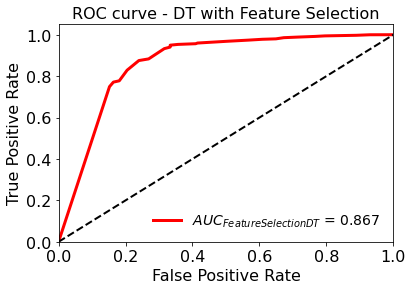

In [44]:
# y_score0 --> scores of decision tree without PCA
# fpr0, tpr0 ---> false positive and true positive of decision tree without PCA
y_score0 = dtc.predict_proba(X_test_sel)
fpr0, tpr0, _ = roc_curve(y_test, y_score0[:, 1])

# roc_auc0 --> ROC/AUC of decision tree without PCA
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='red', lw=3, label='$AUC_{Feature Selection DT}$ = %.3f' % roc_auc0)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve - DT with Feature Selection', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### Confusion matrix

Legend:
0: Jazz
1: Rock
[[  40  131]
 [  35 4220]]


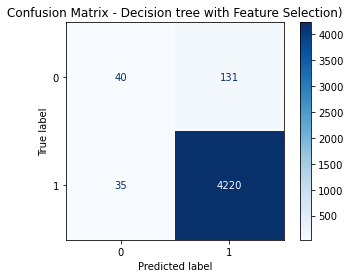

In [45]:
# confusion matrix - Internal Test
print("Legend:\n0: Jazz"
      "\n1: Rock")
cm = plot_confusion_matrix(dtc,X_test_sel,y_test,
                            cmap = plt.cm.Blues)
cm.ax_.set_title('Confusion Matrix - Decision tree with Feature Selection)')
print(cm.confusion_matrix)
plt.show()

# KNN (SeleckKBest Feature Selection)

In [60]:
sel = SelectKBest(k=100)
X_develop_k_sel = sel.fit_transform(X_develop, y_develop)
X_develop_k_sel.shape

(10327, 100)

In [61]:
X_test_k_sel = sel.transform(X_test)

### K = 100

In [52]:
# range of k to try - find a good range of k
k_range = {"n_neighbors":[x for x in range(2, 50)]}

knn = KNeighborsClassifier()
rep_kfold = RepeatedKFold(n_splits=10, n_repeats=2, random_state=2652124)
clf = GridSearchCV(knn, param_grid= k_range, cv=rep_kfold )
clf.fit(X_develop_k_sel, y_develop)
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")

KeyboardInterrupt: 

In [62]:
knn =  KNeighborsClassifier(n_neighbors = 29, weights='distance')
# retrain knn on the whole development set
knn.fit(X_develop_k_sel, y_develop)
# predict target variable
y_pred_knn0 = knn.predict(X_test_k_sel)

# display classification report
print(classification_report(y_test, y_pred_knn0))
print('legend:\n0: Jazz\n1: Rock')

              precision    recall  f1-score   support

           0       0.68      0.35      0.46       171
           1       0.97      0.99      0.98      4255

    accuracy                           0.97      4426
   macro avg       0.83      0.67      0.72      4426
weighted avg       0.96      0.97      0.96      4426

legend:
0: Jazz
1: Rock


In [49]:
dt = {
    'name': 'SelectKBest KNN', 
    'accuracy': accuracy_score(y_test, y_pred_knn0), 
    'f1_score': f1_score(y_test, y_pred_knn0, average=None)[0], 
    'precision': precision_score(y_test, y_pred_knn0, average=None)[0], 
    'recall': recall_score(y_test, y_pred_knn0, average=None)[0]
}
results.append(dt)
dt

{'name': 'SelectKBest KNN',
 'accuracy': 0.9685946678716674,
 'f1_score': 0.4633204633204632,
 'precision': 0.6818181818181818,
 'recall': 0.3508771929824561}

#### ROC curve

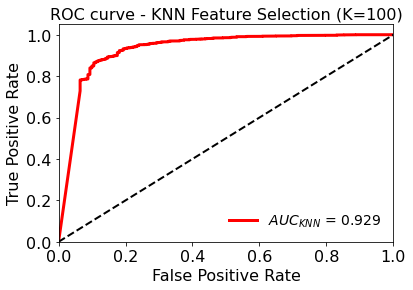

In [63]:
y_score_knn0 = knn.predict_proba(X_test_k_sel)
fpr_knn0, tpr_knn0, _ = roc_curve(y_test, y_score_knn0[:, 1])
roc_auc_knn_feat = auc(fpr_knn0, tpr_knn0)

plt.plot(fpr_knn0, tpr_knn0, color='red', lw=3, label='$AUC_{KNN}$ = %.3f' % roc_auc_knn_feat)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve - KNN Feature Selection (K=100)', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

#### Confusion matrix

Legend:
0: Jazz
1: Rock
[[  60  111]
 [  28 4227]]


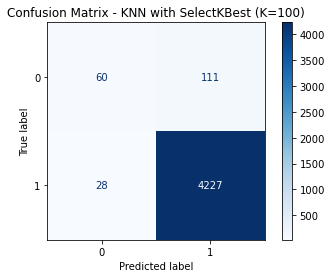

In [64]:
# confusion matrix KNN - Internal test
print("Legend:\n0: Jazz\n1: Rock")
cm_knn = plot_confusion_matrix(knn,X_test_k_sel,y_test,
                            cmap = plt.cm.Blues)
cm_knn.ax_.set_title('Confusion Matrix - KNN with SelectKBest (K=100)')
print(cm_knn.confusion_matrix)
plt.show()

### K = 50

In [53]:
sel = SelectKBest(k=50)
X_develop_k50_sel = sel.fit_transform(X_develop, y_develop)
X_develop_k50_sel.shape

(10327, 50)

In [54]:
X_test_k50_sel = sel.transform(X_test)

In [102]:
# range of k to try - find a good range of k
k_range = {"n_neighbors":[x for x in range(2, 50)]}

knn = KNeighborsClassifier()
rep_kfold = RepeatedKFold(n_splits=10, n_repeats=2, random_state=2652124)
clf = GridSearchCV(knn, param_grid= k_range, cv=rep_kfold )
clf.fit(X_develop_k50_sel, y_develop)
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")

best parameters:
{'n_neighbors': 17}
accuracy: 0.9696432457581965


In [55]:
knn =  KNeighborsClassifier(n_neighbors = 17, weights='distance')
# retrain knn on the whole development set
knn.fit(X_develop_k50_sel, y_develop)
# predict target variable
y_pred_knn50 = knn.predict(X_test_k50_sel)

# display classification report
print(classification_report(y_test, y_pred_knn50))
print('legend:\n0: Jazz\n1: Rock')

              precision    recall  f1-score   support

           0       0.68      0.31      0.43       171
           1       0.97      0.99      0.98      4255

    accuracy                           0.97      4426
   macro avg       0.83      0.65      0.70      4426
weighted avg       0.96      0.97      0.96      4426

legend:
0: Jazz
1: Rock


In [56]:
dt = {
    'name': 'SelectKBest KNN 50', 
    'accuracy': accuracy_score(y_test, y_pred_knn50), 
    'f1_score': f1_score(y_test, y_pred_knn50, average=None)[0], 
    'precision': precision_score(y_test, y_pred_knn50, average=None)[0], 
    'recall': recall_score(y_test, y_pred_knn50, average=None)[0]
}
results.append(dt)
dt

{'name': 'SelectKBest KNN 50',
 'accuracy': 0.9676909173068233,
 'f1_score': 0.42570281124497994,
 'precision': 0.6794871794871795,
 'recall': 0.30994152046783624}

### ROC curve

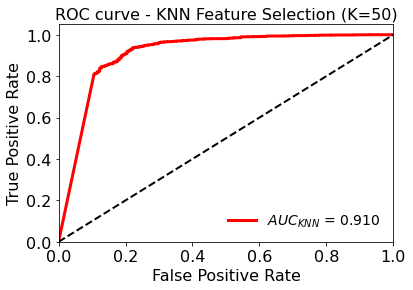

In [57]:
y_score_knn0 = knn.predict_proba(X_test_k50_sel)
fpr_knn0, tpr_knn0, _ = roc_curve(y_test, y_score_knn0[:, 1])
roc_auc_knn_feat = auc(fpr_knn0, tpr_knn0)

plt.plot(fpr_knn0, tpr_knn0, color='red', lw=3, label='$AUC_{KNN}$ = %.3f' % roc_auc_knn_feat)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve - KNN Feature Selection (K=50)', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### Confusion matrix

Legend:
0: Jazz
1: Rock
[[  53  118]
 [  25 4230]]


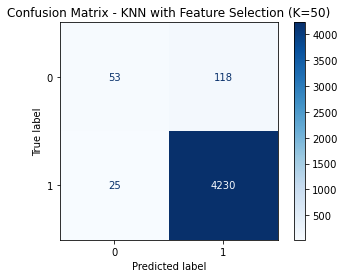

In [59]:
# confusion matrix KNN - Internal test
print("Legend:\n0: Jazz\n1: Rock")
cm_knn = plot_confusion_matrix(knn, X_test_k50_sel, y_test, cmap = plt.cm.Blues)
cm_knn.ax_.set_title('Confusion Matrix - KNN with Feature Selection (K=50)')
print(cm_knn.confusion_matrix)
plt.show()

In [80]:
summarize(results)